# <center><u>Flood Risk Machine Learning Tutorial</u></center>

### Introduction

<p>Urban flooding causes billions of dollars in damages annually, with severe flood events becoming more frequent and destructive as our climate changes. While extreme weather is a primary driver of flooding, its consequences depend on the interconnectedness of urban systems - referred to as the Urban Multiplex, which includes the power grid, transportation network, natural surface water and groundwater systems, sewerage and drinking water systems, intertwined with the socioeconomic and public health sectors.</p>

<p>This tutorial introduces machine learning concepts through an application in one component of the Urban Multiplex - building classification. Accurate and standardized information about buildings (e.g. classification into residential, commercial, industrial) is critical for assessing the number of people affected by flooding, the propagation of shocks throughout the economy, and for forecasting detailed socioeconomic risk from flooding. Yet, a major discrepancy exists in the way data about buildings are collected across the U.S. There is no harmonization in what data are recorded by city, county, or state governments, let alone at the national scale.</p>

<p>In this tutorial we explore multiple means of classifying a building (residential/classification/industrial/etc.) based on its features (location, square footage, proximity to other resources, etc.). Moreover, we are interested in how accurate our machine learning models can be using only free and open data. The data used in this tutorial is consistently and openly available for the continental Unites States. We use the state of North Carolina as an expemplar in this tutorial.</p>

<p>It is currently unknown which building features (e.g. location, square footage, etc.) have the most predictive power. As a result, part of this tutorial focuses on the notion of "feature importance". We've generated a set of features that may be useful for predicting building type. As we work through the examples, we'll also investigate how important each of these features actually is to predicting a building type.</p>

#### Import required Python libraries

In [1]:
import time
import joblib
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pretty_confusion_matrix import pp_matrix_from_data

import tensorflow as tf
from keras.utils import to_categorical
from tensorflow.keras.layers import Dense
from keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential

from sklearn import preprocessing
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.model_selection import KFold
from sklearn.metrics import precision_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

#### Setup and Configuration

In [2]:
# North Carolina data
url = "https://github.com/geo-smart/flood-risk-ml-tutorial/blob/main/North_Carolina_Buildings.zip?raw=true"

# read data into a Pandas dataframe
rawDf = pd.read_csv(url, compression="zip")

# ignore first few columns, which are FIPs codes, not needed for ML
rawDf = rawDf.iloc[:, 3:] 
df = rawDf.copy( deep=True )

#### The data

Our goal is to predict a building's type (Residential/Commercial/Industrial) based on known features of the building (area, location, etc.). To accomplish this, we gather as many building features as possible from open datasets. We begin with as large a set as possible and will work towards identifying each feature's actual importance. 

Our sources of building features are [Open Street Map (OSM)](https://www.openstreetmap.org), the [Multi-Resolution Land Characteristics Consortium (MRLC)](https://www.mrlc.gov/data/type/urban-imperviousness), [United States Census' County Business Patterns (CBP)](https://www.census.gov/programs-surveys/cbp/data/tables.html), and the [United States Census' American Community Survey (ACS)](https://www.census.gov/programs-surveys/acs/data.html).

We've preprocessed the data to spatially align all the features. For example, we used building longitude and latitude provided by OSM to determine which county the building resides in. We've then gone to the ACS and looked up socio-econimic data such as median income and housing density. The resulting machine learning ready data looks like this:

| Column      | Description | Source |
| :---------: | :---------- |:-------|
| X                    | X coordinate of the building in the EPGS:5070 system  | OSM |
| Y                    | Y coordinate of the building in the EPGS:5070 system  | OSM |
| Area                 | Area of building in square meters        | OSM |
| MedianIncomeCounty   | Median income of the county in which the building resides        | ACS |
| HousingUnitsCounty   | Number of housing units in the county in which the building resides | ACS |
| HousingDensityCounty | Number of housing units in the county divided by the number of people residing in the county where the building resides        | ACS |
| Impervious           | Percentage of the area surrounding the building that is comprised of impervious surfaces such as roads and other paved surfaces. Value provided is the mean area weighted average of imperviousness underneath the building footprint  | MRLC |
| AgCount              | Number of agricultural businesses in the county in which the building resides | CBP |
| CmCount              | Number of commercial businesses in the county in which the building resides   | CBP |
| GvCount              | Number of government buildings in the county in which the building resides    | CBP |
| EdCount              | Number of educational buildings in the county in which the building resides   | CBP |
| InCount              | Number of industrial buildings in the county in which the building resides    | CBP |
| OsmNearestRoad       | Type of nearest road to the building | OSM |
| BuildingType             | Building classification | FEMA |

The last column, 'BuildingType', is what we are trying to predict. [USA Structures](https://gis-fema.hub.arcgis.com/pages/usa-structures) is an open source building inventory provided by the Department of Homeland Security, FEMA, Oak Ridge National Laboratory, and the U.S. Geological Survey. The building inventory contains a Building Occupany Type, which was determined through census and U.S. mail data. Currently, Building Occupancy Type values are availble for nine states. However, we note that not every building in those nine states has a manually identified occupany type. We are using North Carolina Building Occupany Type data as our "ground-truth". If we can predict known building types well, the machine learning models can be reliably deployed on unknown buildings and in states where Building Occupany Type is unavailable.

In [3]:
rawDf.head()

,X,Y,Area,MedianIncomeCounty,HousingUnitsCounty,HousingDensityCounty,Impervious,AgCount,CmCount,GvCount,EdCount,InCount,OsmNearestRoad,BuildingType
0,-83.261157,35.484491,21.951055,22429.0,26649.0,0.618177,4.000000,22,2860,3,51,804,residential,Residential
1,-83.260972,35.484583,255.155551,22429.0,26649.0,0.618177,5.666667,22,2860,3,51,804,residential,Residential
2,-83.260417,35.484768,184.625376,22429.0,26649.0,0.618177,7.000000,22,2860,3,51,804,residential,Residential
3,-83.256806,35.492268,434.205428,22429.0,26649.0,0.618177,22.500000,22,2860,3,51,804,residential,Residential
4,-83.156435,35.493657,138.361515,22429.0,26649.0,0.618177,4.000000,22,2860,3,51,804,secondary,Residential


#### Data exploration

In [4]:
# building type distributions
print( "Building types and their counts" )
print()
print( df['BuildingType'].value_counts() )
print()

Building types and their counts

Residential         976690
Commercial           64029
Industrial           16722
Assembly              7323
Education             6457
Government            4910
Agriculture           1651
Utility and Misc       362
Name: BuildingType, dtype: int64



In [5]:
print( "Building type counts as compared to the largest class" )
print()
976690/df['BuildingType'].value_counts()

Building type counts as compared to the largest class



Residential            1.000000
Commercial            15.253869
Industrial            58.407487
Assembly             133.372935
Education            151.260647
Government           198.918534
Agriculture          591.574803
Utility and Misc    2698.038674
Name: BuildingType, dtype: float64

<p>We have significant class imbalance. For example, the residential buildings outnumber the commercial buildings 15 to 1. The residentail buildings outnumber the agricultural buildings nearly 600 to 1. This can be a challenge for machine learning classification algorithms. The algorithm may not "learn", but rather obtain high accuracy simply by picking the majority class.</p>

<p>We will look at techniques for dealing with such imbalance</p>

### Use case driven model selection

The type of classification model needed depends on the application. For example, during a flood emergency, first responders may only be interested in identifying residential buildings. In this use case, binary classification (Residential vs. non-Residential) is sufficient. 

However, for ecomomic applications, multiclass classification is needed, i.e. Residential vs. Commercial vs. Industrial vs. ...

We provide examples of both scenarios.

### Binary classification

First, we need to preprocess the data and prepare it for machine learning. For this binary classification example, all non-Residential building types are changed to "Other".

<p>The OsmNearestRoad and OrnlType are currently text. We need to encode these as integers before proceeding with machine learning. We also want to scale our columns to a common axis so that columns with large values don't bias the learning.</p>

<p>We'll use a standard scaler, which scales based on the standard scoreas: z = (x - u) / s</p>
<p>Where u is the mean of the training samples and s is the standard deviation of the training samples</p>

In [6]:
df.loc[df["BuildingType"] != "Residential", "BuildingType"] = 'Other'

df = df.sample(frac=1) # shuffle the dataframe (technically, we randomly resample the entire df)

# preprocess the data - scaling
scaler = preprocessing.StandardScaler()
    
columns = ['X', 'Y', 'Area', 'MedianIncomeCounty', 
           'HousingUnitsCounty', 'HousingDensityCounty',
           'Impervious', 'AgCount', 'CmCount', 'GvCount',
           'EdCount', 'InCount']
df[columns] = scaler.fit_transform(df[columns])

# preprossing - drop rows with NaN values
df = df.dropna()
    
# preprocessing - change output labels from text ('Agriculture') to integers
nCols = df.shape[1]
le = preprocessing.LabelEncoder()
le.fit( df.iloc[:, nCols-1] )
df.iloc[:, nCols-1] = le.transform( df.iloc[:, nCols-1] )
        
# preprocessing - change output labels of nearest road type from text to integers
le2 = preprocessing.LabelEncoder()
le2.fit( df.iloc[:, nCols-2] ) 
df.iloc[:, nCols-2] = le2.transform( df.iloc[:, nCols-2] )

<p>Some machine learning algorithms, e.g. Random Forest, don't require scaling. We'll create a second dataframe with OsmNearestRoad and BuildingType encoded, but without the scaling</p> 

In [7]:
rawDf.loc[rawDf["BuildingType"] != "Residential", "BuildingType"] = 'Other'

rawDf = rawDf.sample(frac=1) # shuffle the dataframe (technically, we randomly resample the entire df)

rawDf = rawDf.dropna()

nCols = rawDf.shape[1]
le = preprocessing.LabelEncoder()
le.fit( rawDf.iloc[:, nCols-1] ) # ornl type
rawDf.iloc[:, nCols-1] = le.transform( rawDf.iloc[:, nCols-1] )
    
le2 = preprocessing.LabelEncoder()
le2.fit( rawDf.iloc[:, nCols-2] ) # nearest road type
rawDf.iloc[:, nCols-2] = le2.transform( rawDf.iloc[:, nCols-2] )

<p>Our "BuildingType" values are now encoded as 0 or 1. We can use the inverse_transform to see which one is which.</p>

In [8]:
df.head()

,X,Y,Area,MedianIncomeCounty,HousingUnitsCounty,HousingDensityCounty,Impervious,AgCount,CmCount,GvCount,EdCount,InCount,OsmNearestRoad,BuildingType
963767,0.710923,0.573174,-0.176558,1.302284,0.963812,-0.339621,-0.519858,1.665731,0.880503,0.643556,1.097817,1.041934,4,1
988894,0.825657,0.266649,-0.065683,1.302284,0.963812,-0.339621,-1.160999,1.665731,0.880503,0.643556,1.097817,1.041934,4,1
818879,0.908104,0.862325,-0.207194,1.302284,0.963812,-0.339621,1.165003,1.665731,0.880503,0.643556,1.097817,1.041934,4,1
962542,0.721475,0.138977,-0.065971,1.302284,0.963812,-0.339621,0.594685,1.665731,0.880503,0.643556,1.097817,1.041934,4,1
329885,-0.102134,1.262338,0.495512,-0.937660,-0.273707,0.026131,1.936610,-0.758292,-0.383523,-0.202516,-0.520841,-0.321399,4,0


In [9]:
le.inverse_transform([0,1])

array(['Other', 'Residential'], dtype=object)

In [74]:
le2.inverse_transform( rawDf.iloc[:, nCols-2].unique() )

array(['residential', 'primary', 'tertiary', 'secondary', 'trunk',
       'motorway_link', 'motorway', 'trunk_link', 'secondary_link',
       'tertiary_link', 'primary_link'], dtype=object)

In [10]:
df['BuildingType'].value_counts()

1    976689
0    101453
Name: BuildingType, dtype: int64

In [11]:
976689/df['BuildingType'].value_counts()

1    1.00000
0    9.62701
Name: BuildingType, dtype: float64

<p>We still have nearly 10 times more residential buildings as "other" buildings. Let's proceed with various classification techniques and see how we do.</p>

### Random Forest

Random Forest does not require data values to be scaled. Let's apply Random Forest to our unscaled dataframe.

The Random Forest model is a means of combining multiple decision trees to create a “forest.” A decision tree is like a flowchart that draws a clear pathway to a decision (prediction) based the training data. The algorithm determines tree branching based on feature values with each branch of the decision tree offering a different possible outcome.

In [12]:
rawDf.head()

,X,Y,Area,MedianIncomeCounty,HousingUnitsCounty,HousingDensityCounty,Impervious,AgCount,CmCount,GvCount,EdCount,InCount,OsmNearestRoad,BuildingType
1029795,-78.908472,35.948935,106.57920,35085.0,144559.0,0.445026,30.500000,0,26758,12,892,3732,4,1
667149,-80.809213,35.177268,368.90360,36443.0,478966.0,0.429380,41.000000,38,118034,39,2607,17352,4,1
265214,-77.783102,35.979213,1713.15999,26177.0,43154.0,0.454396,84.500000,71,6492,0,64,1176,2,0
1022363,-78.921250,35.925139,151.02380,35085.0,144559.0,0.445026,26.666667,0,26758,12,892,3732,4,1
943591,-78.684491,35.826343,284.79009,41189.0,462582.0,0.409578,49.500000,119,105723,30,2778,17780,4,1


Cross-validation is a resampling procedure used to evaluate machine learning models on a limited data sample.

The procedure has a single parameter called k that refers to the number of groups that a given data sample is to be split into. As such, the procedure is often called k-fold cross-validation. In this tutorial, we split our training data into 5 groups, thus k=5 and our approach is refered to as 5-fold cross-validation.

In machine learning applications, we need to split out data into a training set (what is used to train the machine learning model) and a test set (a portion of data not used in training and reserved for evaluating how well the model is working). Cross-validation allows every data point to be used for both training and evaluation. It also helps us identify if any random splitting of the data results is drastically different performance.

The general procedure is as follows:

1. Shuffle the dataset randomly.
2. Split the dataset into k groups
3. For each unique group:
    Take one group as the test data set
    Take the remaining groups as a training data set
    Fit a model on the training set and evaluate it on the test set
    Retain the evaluation score and discard the model
4. Summarize the skill of the model using the sample of model evaluation scores

In [13]:
kf = KFold( n_splits=5, shuffle=True, random_state=42 )
rf = RandomForestClassifier(class_weight='balanced')

X = rawDf.drop(['BuildingType'], axis=1).values
y = rawDf['BuildingType'].values

accs = []
fold = 1
for trainIndex, testIndex in kf.split(X):
    X_train, X_test = X[trainIndex], X[testIndex]
    y_train, y_test = y[trainIndex], y[testIndex]
    rf.fit( X_train, y_train )
    predictions = rf.predict(X_test)
    ba = np.round( balanced_accuracy_score(y_test, predictions), 4 )
    accs.append( ba )
    print( "Fold:", fold )
    print( "  Balanced Accuracy:", ba)
    print( "  Weighted F1:", np.round( f1_score(y_test, predictions, average='weighted'), 4 ))
    print( "  Weighted Precision:", np.round( precision_score(y_test, predictions, average='weighted'), 4 ))
    print( "  Weighted Recall:", np.round( recall_score(y_test, predictions, average='weighted'), 4 ))
    print()
    fold += 1
print( "Average Balanced Accuracy:", np.round(np.mean(accs),4) )

Fold: 1
  Balanced Accuracy: 0.855
  Weighted F1: 0.9602
  Weighted Precision: 0.9599
  Weighted Recall: 0.9616

Fold: 2
  Balanced Accuracy: 0.8526
  Weighted F1: 0.9605
  Weighted Precision: 0.9603
  Weighted Recall: 0.9621

Fold: 3
  Balanced Accuracy: 0.8545
  Weighted F1: 0.9609
  Weighted Precision: 0.9606
  Weighted Recall: 0.9623

Fold: 4
  Balanced Accuracy: 0.8538
  Weighted F1: 0.9602
  Weighted Precision: 0.9599
  Weighted Recall: 0.9616

Fold: 5
  Balanced Accuracy: 0.8578
  Weighted F1: 0.9615
  Weighted Precision: 0.9612
  Weighted Recall: 0.9628

Average Balanced Accuracy: 0.8547


We get very similar performance across all folds, which is good. Overall, the random forest approach can predict "Residential" or "Other" correctly with ~86% accuracy.

We are using balanced accuracy to deal with our imbalanced dataset. It is defined as the average of recall obtained on each class. Similarly, we use micro F1, which is the normal F1 formula but calculated using the total number of True Positives (TP), False Positives (FP) and False Negatives (FN), instead of individually for each class.

Machine Learning models can be saved as [Pickle files](https://scikit-learn.org/stable/model_persistence.html). Although, the Joblib approach, is often preferred as it offers compression.

In [14]:
rf.fit( X_train, y_train )

with open('./rf_model.pkl', 'wb') as f:
    pickle.dump(rf, f)

In [15]:
# read the model from file                                                                                                                                                                                                         
with open('./rf_model.pkl', 'rb') as f:
    rf = pickle.load(f)

predictions = rf.predict(X_test)
print( "Predictions:", predictions[0:5] )
print( "Actual:", y_test[0:5] )

Predictions: [1 1 1 1 1]
Actual: [1 1 1 1 1]


In [16]:
# save the model to a file
joblib.dump(rf, './rf_model.sav', compress=3)

# read the model from file                                                                                                                                                                                                         
rf = joblib.load('./rf_model.sav')

A confustion matrix is a visual display of true positives, true negatives, false positives, and false negatives. Here, by setting normalize='true', we are displaying proportions rather than counts.

In [19]:
cm = confusion_matrix( y_test, predictions, normalize='true' )

In [34]:
font = {'family' : 'normal',
    'weight' : 'bold',
    'size'   : 22}
plt.rc('font', **font)

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


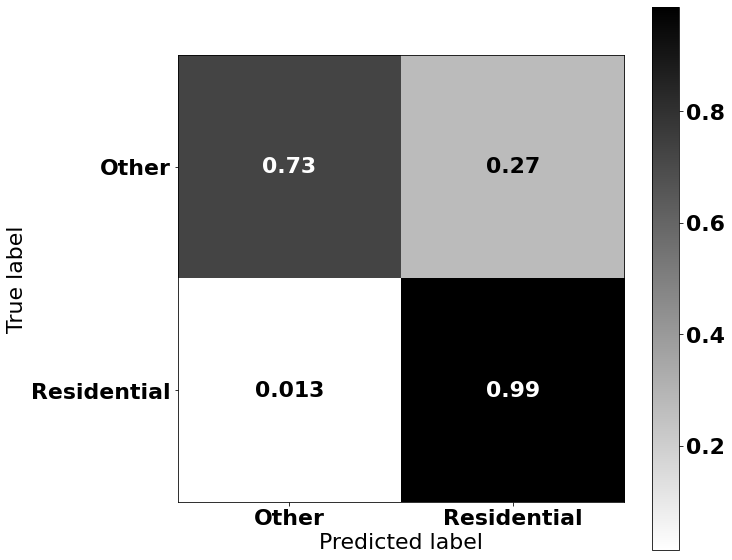

In [35]:
fig, ax = plt.subplots(figsize=(10, 10))
disp = ConfusionMatrixDisplay( confusion_matrix=cm, display_labels=le.inverse_transform([0,1]))#rf.classes_)
disp.plot(ax=ax, cmap='gist_yarg')

### Neural Network

In [36]:
# This is required for my GPU: GeForce RTX 2060
# Without this config, tensorflow cannot properly allocate GPU memory

# This is a GPU specific configuration and may not be needed on your GPU

config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
config.gpu_options.per_process_gpu_memory_fraction = 0.90
session = tf.compat.v1.Session(config=config)

2023-04-27 14:31:17.990417: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-27 14:31:18.066435: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_COMPAT_NOT_SUPPORTED_ON_DEVICE: forward compatibility was attempted on non supported HW
2023-04-27 14:31:18.066535: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: narock.goucher.edu
2023-04-27 14:31:18.066558: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: narock.goucher.edu
2023-04-27 14:31:18.066810: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 525.105.17
2023-04-27 14:31:18.066885: I tensorflow/stream_executor

In [37]:
# columns: StateFips, CountyFips, StateCountyFips,
#          X, Y, Area, MedianIncomeCounty, HousingUnitsCounty,
#          HousingDensityCounty, Impervious, AgCount, CmCount,
#          GvCount, EdCount, InCount, OsmNearestRoad, OrnlType

# test/train split
print("Creating test/train split...")
train, test = train_test_split(df, test_size=0.2, random_state=42, stratify=df[['BuildingType']])

nCols = test.shape[1]
xTest = test.iloc[:, :nCols-2]
yTest = test.iloc[:, nCols-1]

xTrain = train.iloc[:, :nCols-2]
yTrain = train.iloc[:, nCols-1]

Creating test/train split...


In [38]:
print("Training Size:", xTrain.shape)
print("Testing Size:", xTest.shape)

Training Size: (862513, 12)
Testing Size: (215629, 12)


<p>We want the neural network to weight the fewer "other" examples that are available. You can do this by passing Keras weights for each class through a parameter. These will cause the model to "pay more attention" to examples from an under-represented class.</p>

In [39]:
## A common weighting technique that involves the dataset size
## and the number of examples in each class.

# Scaling by total/2 helps keep the loss to a similar magnitude.
total = xTrain.shape[0]
ix = np.where( yTrain == 0 )
zero = len(ix[0])
ix = np.where( yTrain == 1 )
one = len(ix[0])

weight_for_0 = (1 / zero) * (total / 2.0)
weight_for_1 = (1 / one) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 5.31
Weight for class 1: 0.55


<p>Define a fairly simple three layer fully connected neural network</p>
<p>We will set the network to train for 150 epochs; however, we stop the training early if accuracy hasn't improved over the previous 7 epochs</p>

In [40]:
# convert output from scalar to vector format, i.e. building type=2 to [0,0,1,0,0,0,0,0,0,0,0]
y = to_categorical(yTrain)

# define the keras model
model = Sequential()
model.add(Dense(30, input_shape=(xTrain.shape[1],), activation='relu'))
model.add(Dense(15, activation='relu'))
model.add(Dense(2, activation='softmax'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# stop training if we see 7 epochs over which accuracy doesn't improve
es = EarlyStopping(monitor='accuracy', patience=7)

<p>Output a summary of our neural network to see how many trainable parameters there are</p>

In [41]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 30)                390       
                                                                 
 dense_1 (Dense)             (None, 15)                465       
                                                                 
 dense_2 (Dense)             (None, 2)                 32        
                                                                 
Total params: 887
Trainable params: 887
Non-trainable params: 0
_________________________________________________________________


<p>Train the neural network</p>

In [42]:
# fit the model
h = model.fit(xTrain, y, epochs=150, batch_size=256, class_weight=class_weight, callbacks=[es])

Epoch 1/150
3370/3370 [==============================] - 6s 2ms/step - loss: 0.3577 - accuracy: 0.8811
Epoch 2/150
3370/3370 [==============================] - 5s 1ms/step - loss: 0.3393 - accuracy: 0.8919
Epoch 3/150
3370/3370 [==============================] - 4s 1ms/step - loss: 0.3337 - accuracy: 0.8924
Epoch 4/150
3370/3370 [==============================] - 4s 1ms/step - loss: 0.3303 - accuracy: 0.8928
Epoch 5/150
3370/3370 [==============================] - 5s 1ms/step - loss: 0.3279 - accuracy: 0.8927
Epoch 6/150
3370/3370 [==============================] - 4s 1ms/step - loss: 0.3259 - accuracy: 0.8931
Epoch 7/150
3370/3370 [==============================] - 4s 1ms/step - loss: 0.3250 - accuracy: 0.8935
Epoch 8/150
3370/3370 [==============================] - 4s 1ms/step - loss: 0.3241 - accuracy: 0.8934
Epoch 9/150
3370/3370 [==============================] - 4s 1ms/step - loss: 0.3232 - accuracy: 0.8937
Epoch 10/150
3370/3370 [==============================] - 4s 1ms/step - l

Text(0.5, 0, 'Epoch')

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


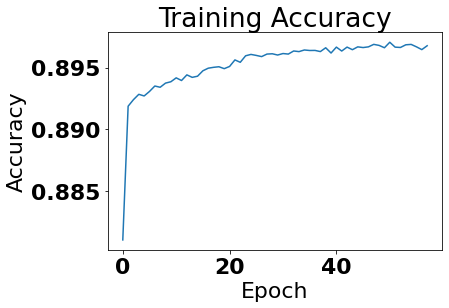

In [43]:
plt.plot( h.history['accuracy'] )
plt.title('Training Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

In [44]:
model.save_weights("./nn_model.h5")

Evaluate the neural network on the test set

In [45]:
y = to_categorical(yTest)
loss, acc = model.evaluate( xTest, y )
print("Accuracy on the test set:", np.round(acc,4))

6739/6739 [==============================] - 14s 2ms/step - loss: 0.3009 - accuracy: 0.8939
Accuracy on the test set: 0.8939


Use Balanced Accuracy and Micro F1 to get a better sense of how we did

In [46]:
ps = model.predict(xTest)
predictions = []
for p in ps:
    predictions.append( np.argmax( p ) )
len(predictions)

6739/6739 [==============================] - 3s 455us/step


215629

In [47]:
print( "Balanced Accuracy:", np.round( balanced_accuracy_score(yTest.values, predictions), 4 ))
print( "Weighted F1:", np.round( f1_score(yTest.values, predictions, average='weighted'), 4 ))
print( "Weighted Precision:", np.round( precision_score(yTest.values, predictions, average='weighted'), 4 ))
print( "Weighted Recall:", np.round( recall_score(yTest.values, predictions, average='weighted'), 4 ))

Balanced Accuracy: 0.8728
Weighted F1: 0.907
Weighted Precision: 0.9339
Weighted Recall: 0.8939


In [48]:
cm = confusion_matrix( yTest.values, predictions, normalize='true' )

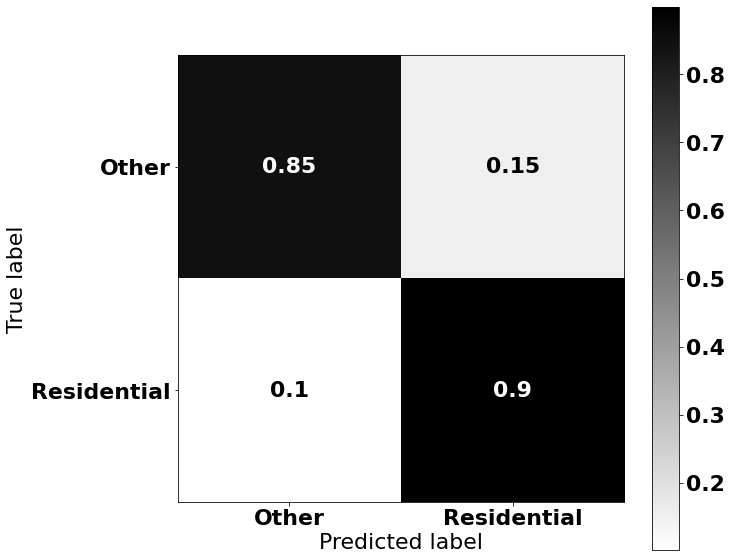

In [49]:
fig, ax = plt.subplots(figsize=(10, 10))
disp = ConfusionMatrixDisplay( confusion_matrix=cm, display_labels=le.inverse_transform([0,1]))#rf.classes_)
disp.plot(ax=ax, cmap='gist_yarg')

## Feature Importance

<p>Feature importance is a technique for assessing how important each of our input features are to making accurate predictions. Features with low importance do not contribute much (are not used/do not have much weight) to prediction accuracy. Low importance features can be ignored creating simpler more scalable machine learning modesl.</p>

We use a technique called [Permutation Importance](https://scikit-learn.org/stable/modules/permutation_importance.html) in which features are randomly shuffled. If a column's values can be randomly shuffled and prediction accuracy does not decrease, then that feature has low importance.

<p>We'll use our Random Forest model to demonstrate feature importance</p>

In [65]:
start_time = time.time()
result = permutation_importance(rf, X_test, y_test, n_repeats=10, random_state=42, n_jobs=1)
elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

Elapsed time to compute the importances: 419.344 seconds


In [66]:
font = {'family' : 'normal',
    'weight' : 'normal',
    'size'   : 16}
plt.rc('font', **font)

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


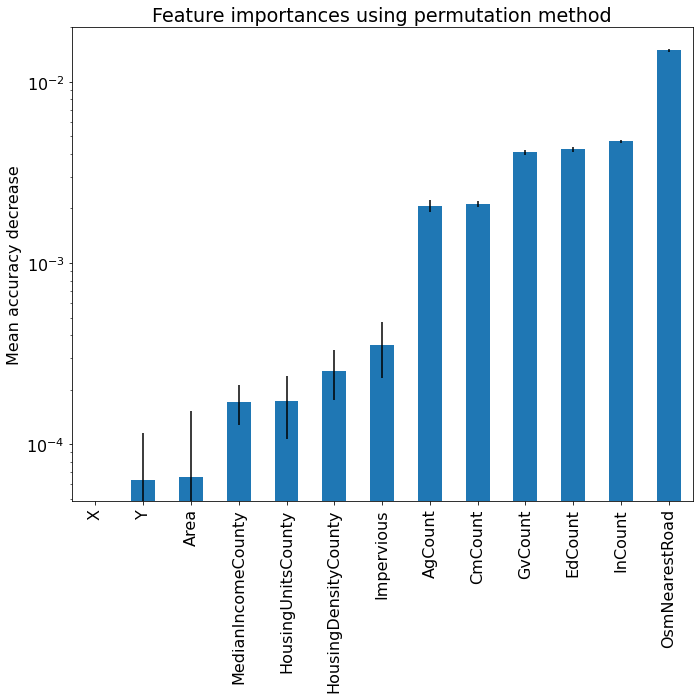

In [68]:
sorted_idx = result.importances_mean.argsort()
forest_importances = pd.Series(result.importances_mean[sorted_idx], index=rawDf.columns[:-1])

fig, ax = plt.subplots( figsize=(10, 10) )
forest_importances.plot.bar(yerr=result.importances_std[sorted_idx], ax=ax)
ax.set_title("Feature importances using permutation method")
ax.set_ylabel("Mean accuracy decrease")
ax.set_yscale('log')
fig.tight_layout()
plt.show()

The features 'HousingUnitsCounty', 'HousingDensityCounty', 'AgCount', 'CmCount', 'GvCount', 'EdCount', and 'InCount' have low importance. Let's retrain a smaller Random Forest model without those features

### Remove features that are not important/helpful to simplify the model

In [58]:
kf = KFold( n_splits=5, shuffle=True, random_state=42 )
rf = RandomForestClassifier(class_weight='balanced')

X = rawDf.drop(['BuildingType', 'HousingUnitsCounty', 'HousingDensityCounty', 'AgCount', 'CmCount',
                'GvCount', 'EdCount', 'InCount'], axis=1).values
y = rawDf['BuildingType'].values

accs = []
for trainIndex, testIndex in kf.split(X):
    X_train, X_test = X[trainIndex], X[testIndex]
    y_train, y_test = y[trainIndex], y[testIndex]
    rf.fit( X_train, y_train )
    ba = np.round( balanced_accuracy_score(y_test, rf.predict(X_test)), 4 )
    accs.append( ba )
    print( "Balanced Accuracy:", ba)
    print( "Micro F1:", np.round( f1_score(y_test, rf.predict(X_test), average='micro'), 4 ))
    print()
print( "Average Balanced Accuracy:", np.round(np.mean(accs),4) )

Balanced Accuracy: 0.8482
Micro F1: 0.9603

Balanced Accuracy: 0.8477
Micro F1: 0.9599

Balanced Accuracy: 0.8498
Micro F1: 0.9605

Balanced Accuracy: 0.8435
Micro F1: 0.9593

Balanced Accuracy: 0.8464
Micro F1: 0.9601

Average Balanced Accuracy: 0.8471


Our average Balanced Accuracy from the previous Random Forest model using all the features was 85.48%. Our reduced model has accuracy of 84.71%. We can create a smaller model without much loss in accuracy.

In [59]:
with open('./rf_reduced_model.pkl', 'wb') as f:
    pickle.dump(rf, f)

## Strategies to deal with unbalanced classes

Undersampling refers to a group of techniques designed to balance the class distribution. Undersampling techniques remove examples from the training dataset that belong to the majority class in order to better balance the class distribution. 

This is in contrast to oversampling, which involves adding examples to the minority class in an effort to reduce the class distribution imbalance.

Near Miss refers to a collection of undersampling methods that select examples based on the distance of majority class examples to minority class examples.

The approaches were proposed by Jianping Zhang and Inderjeet Mani in their 2003 paper [KNN Approach to Unbalanced Data Distributions: A Case Study Involving Information Extraction](https://www.site.uottawa.ca/~nat/Workshop2003/jzhang.pdf)

There are three versions of the technique, named NearMiss-1, NearMiss-2, and NearMiss-3.

* NearMiss-1 selects examples from the majority class that have the smallest average distance to the k closest examples from the minority class. 
* NearMiss-2 selects examples from the majority class that have the smallest average distance to the k furthest examples from the minority class. 
* NearMiss-3 involves selecting a given number of majority class examples for each example in the minority class that are closest.

Distance is determined in feature space using Euclidean distance.

We'll use NearMiss-3, which keeps majority class examples that are on the decision boundary.

In [67]:
from imblearn.under_sampling import NearMiss

# define the undersampling method
undersample = NearMiss( version=3, n_neighbors_ver3=5 )

X = rawDf.drop(['BuildingType'], axis=1).values
y = rawDf['BuildingType'].values

# transform the dataset
X, y = undersample.fit_resample( X, y )

In [68]:
ix = np.where( y == 1 )
print( "Residential:", len(ix[0]) )

ix = np.where( y == 0 )
print( "Other:", len(ix[0]) )

Residential: 101453
Other: 101453


### Random Forest example of Near-Miss

In [69]:
kf = KFold( n_splits=5, shuffle=True, random_state=42 )
rf = RandomForestClassifier(class_weight='balanced')

accs = []
for trainIndex, testIndex in kf.split(X):
    X_train, X_test = X[trainIndex], X[testIndex]
    y_train, y_test = y[trainIndex], y[testIndex]
    rf.fit( X_train, y_train )
    predictions = rf.predict(X_test)
    ba = np.round( balanced_accuracy_score(y_test, predictions), 4 )
    accs.append( ba )
    print( "Balanced Accuracy:", ba)
    print( "Weighted F1:", np.round( f1_score(y_test, predictions, average='weighted'), 4 ))
    print( "Weighted Precision:", np.round( precision_score(y_test, predictions, average='weighted'), 2 ) )
    print( "Weighted Recall:", np.round( recall_score(y_test, predictions, average='weighted'), 2 ) )
    print()
print( "Average Balanced Accuracy:", np.round(np.mean(accs),4) )

Balanced Accuracy: 0.842
Weighted F1: 0.842
Weighted Precision: 0.84
Weighted Recall: 0.84

Balanced Accuracy: 0.8419
Weighted F1: 0.8419
Weighted Precision: 0.84
Weighted Recall: 0.84

Balanced Accuracy: 0.8394
Weighted F1: 0.8394
Weighted Precision: 0.84
Weighted Recall: 0.84

Balanced Accuracy: 0.841
Weighted F1: 0.841
Weighted Precision: 0.84
Weighted Recall: 0.84

Balanced Accuracy: 0.8409
Weighted F1: 0.8409
Weighted Precision: 0.84
Weighted Recall: 0.84

Average Balanced Accuracy: 0.841


Our average Balanced Accuracy from the original Random Forest model was 85.48%. The Balanced Accuracy using Near-Miss-3 and balanced classed results in an accuracy of 84%. This technique was not particularly helpful for our application.

In [70]:
with open('./rf_balanced_model.pkl', 'wb') as f:
    pickle.dump(rf, f)

### Threshold Moving

Perhaps the simplest approach to handle a severe class imbalance is to change the decision threshold. Many classification algorithms will return a probability of class membership where all values equal or greater than a threshold are mapped to one class and all other values are mapped to the other class. The default of many algorithms is to set the threshold at 0.5. Threshold moving simply moves the threshold attempting to achieve higher accuracy.

In [71]:
from matplotlib import pyplot
from sklearn.metrics import precision_recall_curve

# generate dataset
X = rawDf.drop(['BuildingType'], axis=1).values
y = rawDf['BuildingType'].values

# split into train/test sets
trainX, testX, trainy, testy = train_test_split(X, y, test_size=0.2, random_state=2, stratify=y)

# fit a model
print("Fitting the model...")
model = RandomForestClassifier(class_weight='balanced')
model.fit(trainX, trainy)

# predict probabilities
print("Making predictions...")
yhat = model.predict_proba(testX)

# keep probabilities for the positive outcome only
yhat = yhat[:, 1]

# calculate precision-recall curve
print("Generating precision-recall curve...")
precision, recall, thresholds = precision_recall_curve(testy, yhat)

Fitting the model...
Making predictions...
Generating precision-recall curve...


In [75]:
# convert to f score
fscore = (2 * precision * recall) / (precision + recall)

# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))

Best Threshold=0.550000, F-Score=0.979


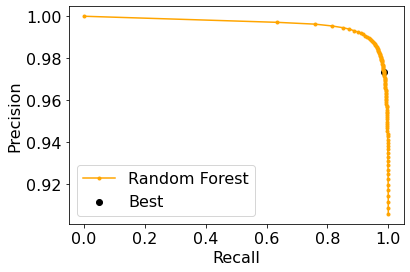

In [78]:
# plot the curve for the model
no_skill = len(testy[testy==1]) / len(testy)
pyplot.plot(recall, precision, marker='.', label='Random Forest', color='orange')
pyplot.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best')

# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
pyplot.legend()

# show the plot
pyplot.show()

Now that we've found the best threshold, what accuracy can we achieve with it?

In [79]:
threshold = 0.55

predicted_proba = model.predict_proba(testX)
predicted = (predicted_proba [:,1] >= threshold).astype('int')

ba = np.round( balanced_accuracy_score(testy, predicted), 4 )

print( "Balanced Accuracy:", ba)
print( "Weighted F1:", np.round( f1_score(testy, predicted, average='weighted'), 4 ))
print( "Weighted Precision:", np.round( precision_score(testy, predicted, average='weighted'), 2 ) )
print( "Weighted Recall:", np.round( recall_score(testy, predicted, average='weighted'), 2 ) )

Balanced Accuracy: 0.8637
Weighted F1: 0.9612
Weighted Precision: 0.96
Weighted Recall: 0.96


In [80]:
with open('./rf_model_threshold_moving.pkl', 'wb') as f:
    pickle.dump(model, f)

## Multiclass Classification

All classes

In [83]:
# read into a Pandas dataframe
rawDf = pd.read_csv( url, compression="zip" )

# ignore first few columns, which are FIPs codes, not needed for ML
rawDf = rawDf.iloc[:, 3:] 

rawDf = rawDf.sample(frac=1) # shuffle the dataframe (technically, we randomly resample the entire df)

rawDf = rawDf.dropna()

nCols = rawDf.shape[1]
le = preprocessing.LabelEncoder()
le.fit( rawDf.iloc[:, nCols-1] ) # ornl type
rawDf.iloc[:, nCols-1] = le.transform( rawDf.iloc[:, nCols-1] )
    
le2 = preprocessing.LabelEncoder()
le2.fit( rawDf.iloc[:, nCols-2] ) # nearest road type
rawDf.iloc[:, nCols-2] = le2.transform( rawDf.iloc[:, nCols-2] )

kf = KFold( n_splits=5, shuffle=True, random_state=42 )
rf = RandomForestClassifier(class_weight='balanced')

X = rawDf.drop(['BuildingType'], axis=1).values
y = rawDf['BuildingType'].values

accs = []
for trainIndex, testIndex in kf.split(X):
    X_train, X_test = X[trainIndex], X[testIndex]
    y_train, y_test = y[trainIndex], y[testIndex]
    rf.fit( X_train, y_train )
    predictions = rf.predict(X_test)
    ba = np.round( balanced_accuracy_score(y_test, predictions), 4 )
    accs.append( ba )
    print( "Balanced Accuracy:", ba)
    print( "Weighted F1:", np.round( f1_score(y_test, predictions, average='weighted'), 4 ))
    print( "Weighted Precision:", np.round( precision_score(y_test, predictions, average='weighted'), 2 ) )
    print( "Weighted Recall:", np.round( recall_score(y_test, predictions, average='weighted'), 2 ) )
    print()
print( "Average Balanced Accuracy:", np.round(np.mean(accs),4) )

Balanced Accuracy: 0.3619
Weighted F1: 0.9395
Weighted Precision: 0.94
Weighted Recall: 0.95

Balanced Accuracy: 0.3579
Weighted F1: 0.9402
Weighted Precision: 0.94
Weighted Recall: 0.95

Balanced Accuracy: 0.3654
Weighted F1: 0.9397
Weighted Precision: 0.94
Weighted Recall: 0.95

Balanced Accuracy: 0.3739
Weighted F1: 0.9405
Weighted Precision: 0.94
Weighted Recall: 0.95

Balanced Accuracy: 0.3645
Weighted F1: 0.9395
Weighted Precision: 0.94
Weighted Recall: 0.95

Average Balanced Accuracy: 0.3647


What does all of this look like if we want to do multi-class classification instead of binary classification? Let's look at another use case where we want to classify a building as "Residential", "Commercial", "Industrial", or "Other".

In [4]:
# read into a Pandas dataframe
rawDf = pd.read_csv( url, compression="zip" )

# ignore first few columns, which are FIPs codes, not needed for ML
rawDf = rawDf.iloc[:, 3:] 

# convert to 'other'
rawDf.loc[rawDf["BuildingType"] == "Assembly", "BuildingType"] = 'Other'
rawDf.loc[rawDf["BuildingType"] == "Education", "BuildingType"] = 'Other'
rawDf.loc[rawDf["BuildingType"] == "Government", "BuildingType"] = 'Other'
rawDf.loc[rawDf["BuildingType"] == "Agriculture", "BuildingType"] = 'Other'
rawDf.loc[rawDf["BuildingType"] == "Utility and Misc", "BuildingType"] = 'Other'

# building type distributions
print()
print( rawDf['BuildingType'].value_counts() )
print()


Residential    976690
Commercial      64029
Other           20703
Industrial      16722
Name: BuildingType, dtype: int64



In [5]:
rawDf = rawDf.sample(frac=1) # shuffle the dataframe (technically, we randomly resample the entire df)

rawDf = rawDf.dropna()

nCols = rawDf.shape[1]
le = preprocessing.LabelEncoder()
le.fit( rawDf.iloc[:, nCols-1] ) # ornl type
rawDf.iloc[:, nCols-1] = le.transform( rawDf.iloc[:, nCols-1] )
    
le2 = preprocessing.LabelEncoder()
le2.fit( rawDf.iloc[:, nCols-2] ) # nearest road type
rawDf.iloc[:, nCols-2] = le2.transform( rawDf.iloc[:, nCols-2] )

kf = KFold( n_splits=5, shuffle=True, random_state=42 )
rf = RandomForestClassifier(class_weight='balanced')

X = rawDf.drop(['BuildingType'], axis=1).values
y = rawDf['BuildingType'].values

accs = []
for trainIndex, testIndex in kf.split(X):
    X_train, X_test = X[trainIndex], X[testIndex]
    y_train, y_test = y[trainIndex], y[testIndex]
    rf.fit( X_train, y_train )
    predictions = rf.predict(X_test)
    ba = np.round( balanced_accuracy_score(y_test, predictions), 4 )
    accs.append( ba )
    print( "Balanced Accuracy:", ba)
    print( "Weighted F1:", np.round( f1_score(y_test, predictions, average='weighted'), 4 ))
    print( "Weighted Precision:", np.round( precision_score(y_test, predictions, average='weighted'), 2 ) )
    print( "Weighted Recall:", np.round( recall_score(y_test, predictions, average='weighted'), 2 ) )
    print()
print( "Average Balanced Accuracy:", np.round(np.mean(accs),4) )

Balanced Accuracy: 0.5633
Weighted F1: 0.9402
Weighted Precision: 0.94
Weighted Recall: 0.95

Balanced Accuracy: 0.5721
Weighted F1: 0.9415
Weighted Precision: 0.94
Weighted Recall: 0.95

Balanced Accuracy: 0.5666
Weighted F1: 0.9407
Weighted Precision: 0.94
Weighted Recall: 0.95

Balanced Accuracy: 0.5687
Weighted F1: 0.9413
Weighted Precision: 0.94
Weighted Recall: 0.95

Balanced Accuracy: 0.5711
Weighted F1: 0.9412
Weighted Precision: 0.94
Weighted Recall: 0.95

Average Balanced Accuracy: 0.5684


Let's try "Residential", "Commercial", or "Other"

In [6]:
# read into a Pandas dataframe
rawDf = pd.read_csv( url, compression="zip" )

# ignore first few columns, which are FIPs codes, not needed for ML
rawDf = rawDf.iloc[:, 3:] 

# drop the rows we don't need
rawDf.loc[rawDf["BuildingType"] == "Industrial", "BuildingType"] = 'Other'
rawDf.loc[rawDf["BuildingType"] == "Assembly", "BuildingType"] = 'Other'
rawDf.loc[rawDf["BuildingType"] == "Education", "BuildingType"] = 'Other'
rawDf.loc[rawDf["BuildingType"] == "Government", "BuildingType"] = 'Other'
rawDf.loc[rawDf["BuildingType"] == "Agriculture", "BuildingType"] = 'Other'
rawDf.loc[rawDf["BuildingType"] == "Utility and Misc", "BuildingType"] = 'Other'

# building type distributions
print()
print( rawDf['BuildingType'].value_counts() )
print()


Residential    976690
Commercial      64029
Other           37425
Name: BuildingType, dtype: int64



In [7]:
# building type distributions
print()
print( 976690/rawDf['BuildingType'].value_counts() )
print()


Residential     1.000000
Commercial     15.253869
Other          26.097261
Name: BuildingType, dtype: float64



## Preprocess

In [8]:
rawDf = rawDf.sample(frac=1) # shuffle the dataframe (technically, we randomly resample the entire df)

rawDf = rawDf.dropna()

nCols = rawDf.shape[1]
le = preprocessing.LabelEncoder()
le.fit( rawDf.iloc[:, nCols-1] ) # ornl type
rawDf.iloc[:, nCols-1] = le.transform( rawDf.iloc[:, nCols-1] )
    
le2 = preprocessing.LabelEncoder()
le2.fit( rawDf.iloc[:, nCols-2] ) # nearest road type
rawDf.iloc[:, nCols-2] = le2.transform( rawDf.iloc[:, nCols-2] )

In [9]:
rawDf.head()

,X,Y,Area,MedianIncomeCounty,HousingUnitsCounty,HousingDensityCounty,Impervious,AgCount,CmCount,GvCount,EdCount,InCount,OsmNearestRoad,BuildingType
348360,-79.763565,36.125509,158.1120,30173.0,232277.0,0.429110,20.000000,21,45798,18,915,8411,7,2
242066,-78.512917,35.509306,255.3460,30833.0,84340.0,0.390465,13.333333,53,10016,4,184,3908,4,2
207083,-77.831528,34.282824,129.6860,31054.0,113368.0,0.502291,12.000000,4,26761,10,469,5181,4,2
174978,-77.897176,34.177824,371.5815,31054.0,113368.0,0.502291,40.666667,4,26761,10,469,5181,4,2
27419,-80.683935,35.400139,438.8767,34297.0,87410.0,0.387106,50.000000,19,14422,6,289,3751,4,2


## Random Forest Multiclass Classifier

In [10]:
kf = KFold( n_splits=5, shuffle=True, random_state=42 )
rf = RandomForestClassifier(class_weight='balanced')

X = rawDf.drop(['BuildingType'], axis=1).values
y = rawDf['BuildingType'].values

accs = []
for trainIndex, testIndex in kf.split(X):
    X_train, X_test = X[trainIndex], X[testIndex]
    y_train, y_test = y[trainIndex], y[testIndex]
    rf.fit( X_train, y_train )
    predictions = rf.predict(X_test)
    ba = np.round( balanced_accuracy_score(y_test, predictions), 4 )
    accs.append( ba )
    print( "Balanced Accuracy:", ba)
    print( "Weighted F1:", np.round( f1_score(y_test, predictions, average='weighted'), 4 ))
    print( "Weighted Precision:", np.round( precision_score(y_test, predictions, average='weighted'), 2 ) )
    print( "Weighted Recall:", np.round( recall_score(y_test, predictions, average='weighted'), 2 ) )
    print()
print( "Average Balanced Accuracy:", np.round(np.mean(accs),4) )

Balanced Accuracy: 0.6741
Weighted F1: 0.9441
Weighted Precision: 0.94
Weighted Recall: 0.95

Balanced Accuracy: 0.6737
Weighted F1: 0.944
Weighted Precision: 0.94
Weighted Recall: 0.95

Balanced Accuracy: 0.6759
Weighted F1: 0.9452
Weighted Precision: 0.94
Weighted Recall: 0.95

Balanced Accuracy: 0.6754
Weighted F1: 0.9444
Weighted Precision: 0.94
Weighted Recall: 0.95

Balanced Accuracy: 0.6683
Weighted F1: 0.9432
Weighted Precision: 0.94
Weighted Recall: 0.95

Average Balanced Accuracy: 0.6735


In [11]:
with open('./rf_model_multi.pkl', 'wb') as f:
    pickle.dump(rf, f)

In [12]:
predictions = rf.predict(X_test)
cm = confusion_matrix( y_test, predictions, normalize='true' )

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


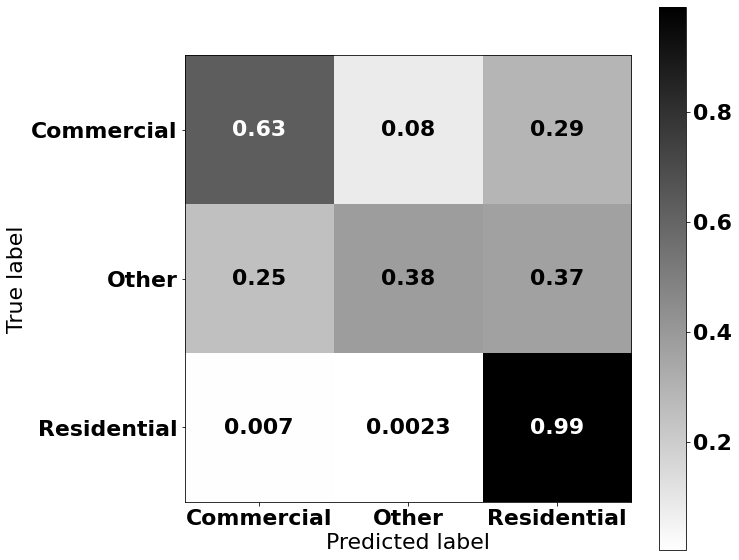

In [13]:
font = {'family' : 'normal',
    'weight' : 'bold',
    'size'   : 22}
plt.rc('font', **font)

fig, ax = plt.subplots(figsize=(10, 10))
disp = ConfusionMatrixDisplay( confusion_matrix=cm, display_labels=le.inverse_transform([0,1,2]))#rf.classes_)
disp.plot(ax=ax, cmap='gist_yarg')

In [14]:
le.inverse_transform( np.arange(0,3,1) )

array(['Commercial', 'Other', 'Residential'], dtype=object)

In [15]:
start_time = time.time()
result = permutation_importance(rf, X_test, y_test, n_repeats=10, random_state=42, n_jobs=1)
elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

Elapsed time to compute the importances: 422.395 seconds


findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


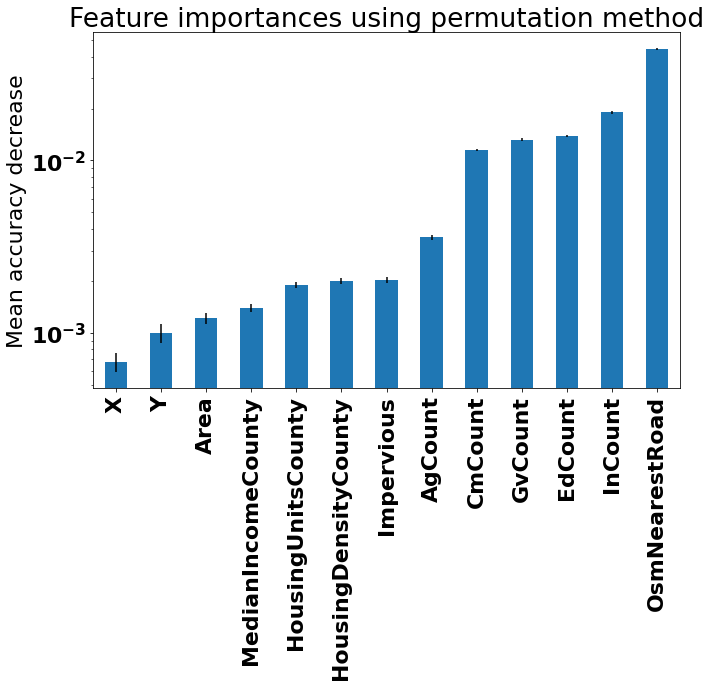

In [16]:
sorted_idx = result.importances_mean.argsort()
forest_importances = pd.Series(result.importances_mean[sorted_idx], index=df.columns[:-1])

fig, ax = plt.subplots( figsize=(10, 10) )
forest_importances.plot.bar(yerr=result.importances_std[sorted_idx], ax=ax)
ax.set_title("Feature importances using permutation method")
ax.set_ylabel("Mean accuracy decrease")
ax.set_yscale('log')
fig.tight_layout()
plt.show()

## One-vs-One Classification

One-vs-One is a multi-class classification strategy for dealing with unbalanced classes. The One-vs-One strategy splits a multi-class classification into one binary classification problem per each pair of classes, e.g. Residentail vs. Commercial, Residential vs. Industrial, Commercial vs. Industrial. The final class assignment is determined by aggregating the results of the binary classifiers.

In [17]:
train, test = train_test_split(rawDf, test_size=0.2, random_state=42, stratify=rawDf[['BuildingType']])

nCols = test.shape[1]
xTest = test.iloc[:, :nCols-2]
yTest = test.iloc[:, nCols-1]

xTrain = train.iloc[:, :nCols-2]
yTrain = train.iloc[:, nCols-1]

print("Training Size:", xTrain.shape)
print("Testing Size:", xTest.shape)

Training Size: (862513, 12)
Testing Size: (215629, 12)


In [18]:
from sklearn.multiclass import OneVsOneClassifier

# define model
rf = RandomForestClassifier(class_weight='balanced')

# define ovo strategy
ovo = OneVsOneClassifier(rf)
ovo.fit( xTrain, yTrain )
    
# make predictions
yhat = ovo.predict(xTest)

ba = np.round( balanced_accuracy_score(yTest, yhat), 4 )
print( "Balanced Accuracy:", ba)
print( "Weighted F1:", np.round( f1_score(yTest, yhat, average='weighted'), 4 ))
print( "Weighted Precision:", np.round( precision_score(yTest, yhat, average='weighted'), 2 ) )
print( "Weighted Recall:", np.round( recall_score(yTest, yhat, average='weighted'), 2 ) )

Balanced Accuracy: 0.645
Weighted F1: 0.9384
Weighted Precision: 0.94
Weighted Recall: 0.94


## One-vs-Rest Classification

The One-vs-Rest strategy is a related approach for dealing with multi-class imbalance. Here, fewer models are created. There is one binary classification problem per class, e.g. Residentail vs. Rest, Commercial vs. Rest, Industrial vs. Rest.

In [19]:
from sklearn.multiclass import OneVsRestClassifier

# define model
rf = RandomForestClassifier(class_weight='balanced')

# define ovr strategy
ovr = OneVsRestClassifier(rf)
ovr.fit( xTrain, yTrain )
    
# make predictions
yhat = ovr.predict(xTest)

ba = np.round( balanced_accuracy_score(yTest, yhat), 4 )
print( "Balanced Accuracy:", ba)
print( "Weighted F1:", np.round( f1_score(yTest, yhat, average='weighted'), 4 ))
print( "Weighted Precision:", np.round( precision_score(yTest, yhat, average='weighted'), 2 ) )
print( "Weighted Recall:", np.round( recall_score(yTest, yhat, average='weighted'), 2 ) )

Balanced Accuracy: 0.6473
Weighted F1: 0.9392
Weighted Precision: 0.94
Weighted Recall: 0.94


### Neural Network for multiclass classification

In [22]:
# Scaling by total/2 helps keep the loss to a similar magnitude.
total = xTrain.shape[0]
ix = np.where( yTrain == 0 )
zero = len(ix[0])
ix = np.where( yTrain == 1 )
one = len(ix[0])
ix = np.where( yTrain == 2 )
two = len(ix[0])

weight_for_0 = (1 / zero) * (total / 2.0)
weight_for_1 = (1 / one) * (total / 2.0)
weight_for_2 = (1 / two) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1, 2: weight_for_2}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))
print('Weight for class 2: {:.2f}'.format(weight_for_2))

Weight for class 0: 8.42
Weight for class 1: 14.40
Weight for class 2: 0.55


In [23]:
# convert output from scalar to vector format, i.e. building type=2 to [0,0,1]
y = to_categorical(yTrain)

# define the keras model
model = Sequential()
model.add(Dense(30, input_shape=(xTrain.shape[1],), activation='relu'))
model.add(Dense(15, activation='relu'))
model.add(Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# stop training if we see 7 epochs over which val_accuracy doesn't improve
es = EarlyStopping(monitor='val_accuracy', patience=7, restore_best_weights=True)

# fit the model
h = model.fit(xTrain, y, epochs=150, batch_size=256, callbacks=[es], \
              class_weight=class_weight, validation_split=0.2)

2023-05-11 15:22:19.808603: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-11 15:22:20.054133: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-11 15:22:20.054367: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-11 15:22:20.056497: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Epoch 1/150
2696/2696 [==============================] - 15s 5ms/step - loss: 451.2835 - accuracy: 0.4303 - val_loss: 121.3688 - val_accuracy: 0.0616
Epoch 2/150
2696/2696 [==============================] - 12s 4ms/step - loss: 89.3031 - accuracy: 0.4163 - val_loss: 9.5930 - val_accuracy: 0.4323
Epoch 3/150
2696/2696 [==============================] - 13s 5ms/step - loss: 42.5724 - accuracy: 0.3823 - val_loss: 1.6108 - val_accuracy: 0.7390
Epoch 4/150
2696/2696 [==============================] - 10s 4ms/step - loss: 28.7446 - accuracy: 0.3727 - val_loss: 25.3638 - val_accuracy: 0.0591
Epoch 5/150
2696/2696 [==============================] - 14s 5ms/step - loss: 9.0845 - accuracy: 0.2738 - val_loss: 1.3378 - val_accuracy: 0.3368
Epoch 6/150
2696/2696 [==============================] - 16s 6ms/step - loss: 1.8896 - accuracy: 0.4200 - val_loss: 1.0525 - val_accuracy: 0.8924
Epoch 7/150
2696/2696 [==============================] - 13s 5ms/step - loss: 1.6636 - accuracy: 0.5986 - val_loss: 

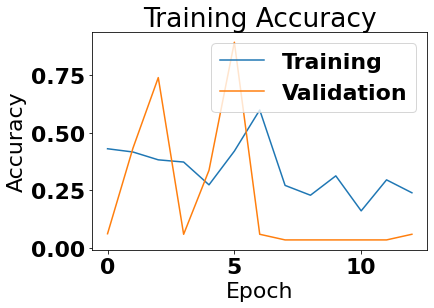

In [24]:
plt.plot( h.history['accuracy'], label='Training' )
plt.plot( h.history['val_accuracy'], label='Validation' )
plt.title('Training Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

In [25]:
y = to_categorical(yTest)
loss, acc = model.evaluate( xTest, y )
print("Accuracy on the test set:", np.round(acc,4))

6739/6739 [==============================] - 7s 980us/step - loss: 1.0510 - accuracy: 0.8916
Accuracy on the test set: 0.8916


In [26]:
ps = model.predict(xTest)
predictions = []
for p in ps:
    predictions.append( np.argmax( p ) )
len(predictions)

6739/6739 [==============================] - 5s 694us/step


215629

In [27]:
print( "Balanced Accuracy:", np.round( balanced_accuracy_score(yTest.values, predictions), 4 ))
print( "Weighted F1:", np.round( f1_score(yTest.values, predictions, average='weighted'), 4 ))
print( "Weighted Precision:", np.round( precision_score(yTest.values, predictions, average='weighted'), 2 ) )
print( "Weighted Recall:", np.round( recall_score(yTest.values, predictions, average='weighted'), 2 ) )

Balanced Accuracy: 0.371
Weighted F1: 0.866
Weighted Precision: 0.85
Weighted Recall: 0.89


### Summary of Results

<p>
<center>Binary Classification</center>

| Approach | Accuracy | Precision | Recall | F1 
-----------|----------|-----------|--------|---
| Random Forest | 85.5% | 96% | 96% | 96%  
| Random Forest w/ balanced classes | 84% | 84% | 84% | 84%
| Random Forest w/ threshold moving | 87% | 96% | 96% | 96%
| Neural Network w/ class weighting | 87% | 94% | 90% | 91% 
</p>

<br/>

<p>
<center>Multiclass Classification</center>
    
| Approach | Accuracy | Precision | Recall | F1 
-----------|----------|-----------|--------|---
| Random Forest | 67% | 94% | 95% | 94%
| Random Forest w/ one-vs-one | 65% | 94% | 94% | 94%
| Random Forest w/ one-vs-rest | 65% | 94% | 94% | 94%
| Neural Network w/ class weighting | 37% | 85% | 89% | 87%
 </p>

### Explainability

Explainable AI is a set of tools and frameworks to help you understand and interpret predictions made by your machine learning models. The various machine learning algorithms have different levels of inherent explainability. For example, random forest models, which are based on decision trees, are more easily able to explain why they made the predictions they did. Neural networks, on the other hand, are more of a black box.

Because of this, we may actually favor the random forest model with threshold moving over the neural network model in the binary classification scenario. Even though the random forest model has slightly worse accuracy, the rationale behind its predictions are much more explainable.

## Classify Unknown Buildings in North Carolina

We can now apply our trained model to a dataset of buildings with unknown type.

In [28]:
# unknown buildings in North Carolina
url = "https://github.com/geo-smart/flood-risk-ml-tutorial/blob/main/unknownBuildings.zip?raw=true"

unknown = pd.read_csv( url, compression="zip" )
unknown.head()

,StateFips,CountyFips,StateCountyFips,X,Y,Area,MedianIncomeCounty,HousingUnitsCounty,HousingDensityCounty,Impervious,AgCount,CmCount,GvCount,EdCount,InCount,OsmNearestRoad,FEMA_100yr
0,37,99,37099,-83.260602,35.484954,20.716411,22429.0,26649.0,0.618177,2.0,22,2860,3,51,804,tertiary,0.0
1,37,99,37099,-83.155694,35.493472,68.605588,22429.0,26649.0,0.618177,6.0,22,2860,3,51,804,secondary,0.0
2,37,99,37099,-83.155694,35.493287,246.025647,22429.0,26649.0,0.618177,8.0,22,2860,3,51,804,secondary,0.0
3,37,99,37099,-83.154768,35.491620,142.232825,22429.0,26649.0,0.618177,0.0,22,2860,3,51,804,secondary,0.0
4,37,99,37099,-83.158009,35.486898,170.658810,22429.0,26649.0,0.618177,0.5,22,2860,3,51,804,residential,0.0


In [29]:
# read the models from file                                                                                                                                                                                                         
with open('./models/rf_model_multi.pkl', 'rb') as f:
    rf = pickle.load(f)

In [30]:
# shuffle the dataframe (technically, we randomly resample the entire df)
unknown = unknown.sample(frac=1) 

unknown = unknown.dropna()

nCols = unknown.shape[1]    
le = preprocessing.LabelEncoder()
le.fit( unknown.iloc[:, nCols-2] ) # nearest road type
unknown.iloc[:, nCols-2] = le.transform( unknown.iloc[:, nCols-2] )

In [31]:
unknown.head()

,StateFips,CountyFips,StateCountyFips,X,Y,Area,MedianIncomeCounty,HousingUnitsCounty,HousingDensityCounty,Impervious,AgCount,CmCount,GvCount,EdCount,InCount,OsmNearestRoad,FEMA_100yr
216003,37,63,37063,-78.890972,36.098843,252.332600,35085.0,144559.0,0.445026,0.250000,0,26758,12,892,3732,4,0.0
53709,37,179,37179,-80.587454,35.114768,69.915638,35468.0,83788.0,0.351656,0.000000,44,13966,6,311,5324,5,0.0
105460,37,19,37019,-78.027176,33.942824,58.454409,30529.0,88330.0,0.646193,52.000000,44,8035,3,113,2188,4,0.0
165499,37,183,37183,-78.443287,35.774306,165.877300,41189.0,462582.0,0.409578,31.666667,119,105723,30,2778,17780,4,0.0
101214,37,115,37115,-82.789120,35.764213,89.803338,26782.0,11045.0,0.521163,0.000000,0,808,0,17,293,4,0.0


In [32]:
print( unknown.shape[0], 'unknown buildings in North Carolina')

219054 unknown buildings in North Carolina


### Make predictions for all unknown buildings in North Carolina

In [33]:
# generate dataset
X = unknown.drop(['StateFips','CountyFips','StateCountyFips','FEMA_100yr'], axis=1).values

# make predictions
predictions = rf.predict(X)

In [34]:
# ['Commercial', 'Other', 'Residential']
pString = []

# update prediction array
for p in predictions:
    if ( p == 0 ):
        pString.append('commercial')
    elif ( p == 1 ):
        pString.append('other')
    elif ( p == 2 ):
        pString.append('residential')

# add a column to the dataframe
unknown['predictions'] = pString

print( unknown['predictions'].value_counts() )

residential    212954
commercial       5324
other             776
Name: predictions, dtype: int64


In [35]:
unknown.head()

,StateFips,CountyFips,StateCountyFips,X,Y,Area,MedianIncomeCounty,HousingUnitsCounty,HousingDensityCounty,Impervious,AgCount,CmCount,GvCount,EdCount,InCount,OsmNearestRoad,FEMA_100yr,predictions
216003,37,63,37063,-78.890972,36.098843,252.332600,35085.0,144559.0,0.445026,0.250000,0,26758,12,892,3732,4,0.0,residential
53709,37,179,37179,-80.587454,35.114768,69.915638,35468.0,83788.0,0.351656,0.000000,44,13966,6,311,5324,5,0.0,residential
105460,37,19,37019,-78.027176,33.942824,58.454409,30529.0,88330.0,0.646193,52.000000,44,8035,3,113,2188,4,0.0,residential
165499,37,183,37183,-78.443287,35.774306,165.877300,41189.0,462582.0,0.409578,31.666667,119,105723,30,2778,17780,4,0.0,residential
101214,37,115,37115,-82.789120,35.764213,89.803338,26782.0,11045.0,0.521163,0.000000,0,808,0,17,293,4,0.0,residential


### Connect predictions with socio-economic data and FEMA 100-year flood predictions

We obtained the 100-year flood map from the FEMA National Flood Hazards Layer. The phrase “100-year flood” is used to describe the extent of a flood that statistically has a 1-percent chance of occurring in any given year [1]. Here, it is used for illustrative purposes of an overall disaster response application. Rows with a 1 in the "FEMA_100yr" column were found be flooded at a significant depth in the FEMA 100-year flood maps.

[1] Maidment, David 2009. “FEMA Flood Map Accuracy.”World Envi-ronmental and Water Resources Congress 2009: Great Rivers1–10.Microsoft. 2018.US Building Footprints.Noy, Natasha, Yuqing Gao, Anshu Ja

In [36]:
flood = unknown[ unknown['FEMA_100yr'] == 1 ]
print(flood.shape[0], "buildings impacted by the 100-year flood")

5838 buildings impacted by the 100-year flood


In [37]:
residential = flood[ flood['predictions'] == 'residential' ]
commercial = flood[ flood['predictions'] == 'commercial' ]
other = flood[ flood['predictions'] == 'other' ]

print("Residential buildings impacted by 100-year flood:", residential.shape[0])
print("Commercial buildings impacted by 100-year flood:", commercial.shape[0])
print("'Other' buildings impacted by 100-year flood:", other.shape[0])

Residential buildings impacted by 100-year flood: 5452
Commercial buildings impacted by 100-year flood: 349
'Other' buildings impacted by 100-year flood: 37


findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


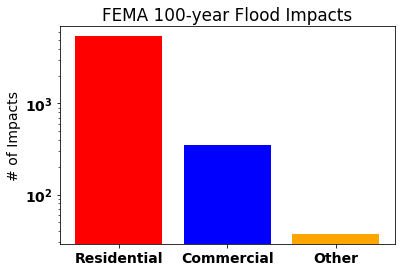

In [41]:
font = {'family' : 'normal',
    'weight' : 'bold',
    'size'   : 14}
plt.rc('font', **font)

fig, ax = plt.subplots()

types = ['Residential', 'Commercial', 'Other']
counts = [ residential.shape[0], commercial.shape[0], other.shape[0]]
bar_colors = ['red', 'blue', 'orange']

ax.bar(types, counts, color=bar_colors)

ax.set_ylabel('# of Impacts')
ax.set_title('FEMA 100-year Flood Impacts')
ax.set_yscale('log')

In [42]:
flood.head()

,StateFips,CountyFips,StateCountyFips,X,Y,Area,MedianIncomeCounty,HousingUnitsCounty,HousingDensityCounty,Impervious,AgCount,CmCount,GvCount,EdCount,InCount,OsmNearestRoad,FEMA_100yr,predictions
59439,37,55,37055,-75.464954,35.575417,31.356867,32538.0,34237.0,0.927455,27.0,40,6497,0,42,1426,4,1.0,residential
76202,37,127,37127,-77.795046,36.004213,105.646083,26177.0,43154.0,0.454396,32.0,71,6492,0,64,1176,4,1.0,residential
110328,37,119,37119,-80.908472,35.468102,17.756795,36443.0,478966.0,0.429380,0.0,38,118034,39,2607,17352,4,1.0,residential
6445,37,65,37065,-77.756713,35.959769,27.812584,24298.0,23059.0,0.471554,7.0,0,1986,0,19,363,4,1.0,residential
73244,37,127,37127,-77.811435,35.949676,203.121948,26177.0,43154.0,0.454396,23.0,71,6492,0,64,1176,4,1.0,residential


In [47]:
fips = []
counts = []
fip = flood['StateCountyFips'].unique()
for f in fip:
    county = flood[ (flood['StateCountyFips'] == f) & (flood['predictions'] == 'residential') ]
    count = county.shape[0]
    counts.append(count) 
    fips.append( str(f) )

In [48]:
df = pd.DataFrame( list(zip(fips, counts)), columns =['fips', 'count'] )

In [49]:
import json
import geojson_rewind
import geopandas as gpd

f = open('./north_carolina.geojson')
counties = json.load(f)
f.close()

counties = geojson_rewind.rewind(counties, rfc7946=False)

In [50]:
import plotly.express as px

fig = px.choropleth( df, geojson=counties, color='count', locations='fips', \
                     color_continuous_scale='Viridis', featureidkey='properties.fip_code') 
fig.update_layout( margin={"r":0, "t":0, "l":0, "b":0} )
fig.show()

Text(0.5, 0, 'Median Individual Income in County')

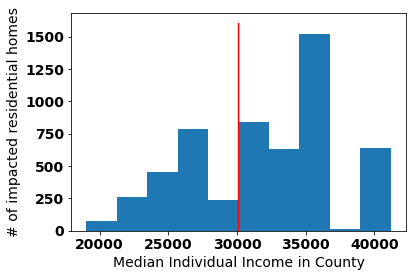

In [51]:
m = 30106 # median individal income in NC in 2020

plt.hist( residential['MedianIncomeCounty'] )
plt.plot( np.zeros(1600)+m, np.arange(0,1600,1), c='red' )
plt.ylabel('# of impacted residential homes')
plt.xlabel('Median Individual Income in County')

In [52]:
ix = np.where( residential['MedianIncomeCounty'] < m )
p = (len(ix[0])/residential['MedianIncomeCounty'].shape[0])*100.
print( np.round(p,2), '% residential buildings impacted are in counties below median income')

33.27 % residential buildings impacted are in counties below median income


Text(0.5, 0, 'Median Individual Income in County')

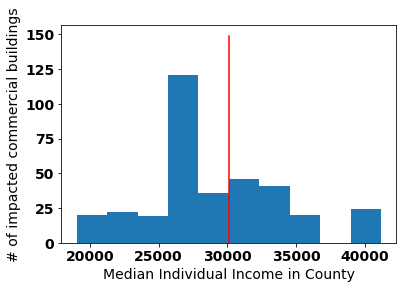

In [53]:
m = 30106 # median individal income in NC in 2020

plt.hist( commercial['MedianIncomeCounty'] )
plt.plot( np.zeros(150)+m, np.arange(0,150,1), c='red' )
plt.ylabel('# of impacted commercial buildings')
plt.xlabel('Median Individual Income in County')

In [54]:
ix = np.where( commercial['MedianIncomeCounty'] < m )
p = (len(ix[0])/commercial['MedianIncomeCounty'].shape[0])*100.
print( np.round(p,2), '% commercial buildings impacted are in counties below median income')

62.46 % commercial buildings impacted are in counties below median income


Text(0.5, 0, 'Median Individual Income in County')

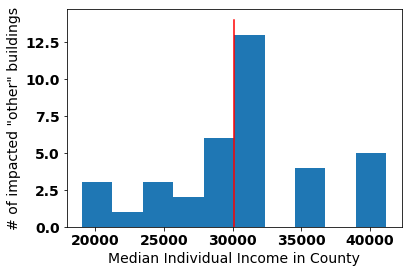

In [56]:
m = 30106 # median individal income in NC in 2020

plt.hist( other['MedianIncomeCounty'] )
plt.plot( np.zeros(15)+m, np.arange(0,15,1), c='red' )
plt.ylabel('# of impacted "other" buildings')
plt.xlabel('Median Individual Income in County')

In [57]:
ix = np.where( other['MedianIncomeCounty'] < m )
p = (len(ix[0])/other['MedianIncomeCounty'].shape[0])*100.
print( np.round(p,2), '% other buildings impacted are in counties below median income')

40.54 % other buildings impacted are in counties below median income


### Conclusions

Our machine learning models enable us to predict the building type for 219,054 buildings in North Carolina. Combining these predictions with socio-economic data and flood forecast models, we are able to make risk assessments that were not possible without the machine learning.

In terms of impacts to residential homes, a 100-year flood will disproportionately impact Mecklenburg, Wake, Dare, and Brunswick counties. Nearly a third of all flooded residential buildings will be in counties where the median income is below the state median. Sixty three percent of commercial buildings predicted to flood during a 100-year flood are in economically disadvantaged counties.

Although buildings are just one small part of the urban multiplex, the application of machine learning can help us better understand this interconnected system leading to enhanced risk assessment and forecasting. 